# Burr
Burr is the best library for implementing the flow chart mental model for agents.

# How it works

### 1. More like FastAPI in approach than LlamaIndex, LangChain, etc.
Good at what it does so you don’t have to be.

### 2. You can use whatever you like inside
This is where you need to be good at what you do; e.g. use haystack, hamilton, langchain, even Burr itself!

### 3. No need to instrument
The framework does a lot of the work for you. E.g. opentelemetry, state checkpoints, etc.

### 4. Annotation & curation
The UI allows you to annotate what has been observed.

### 5. Creating test cases, restarting & forking state
Burr's integrated observability allows you to easily create test cases from prior executions, as well as more easily replay and debug state + code.


# Creating Actions 
A simple counter

In [1]:
import datetime

from burr.core import action, State


@action(reads=["counter"], writes=["counter"])
def increment(state: State) -> State:
    """Increment the counter by 1"""
    current_count = state["counter"]  # get the value from the `state`
    current_count += 1
    print("Count: ", current_count)
    # use `.update()` to create a new `State`
    return state.update(counter=current_count)


@action(reads=["counter"], writes=[])
def exit_counter(state: State) -> State:
    """Print the current count and the current time"""
    current_count = state["counter"]
    print(f"Finished counting to {current_count} at {datetime.datetime.now():%H:%M:%S %Y-%m-%d}")
    return state

# Creating the Graph / flow chart

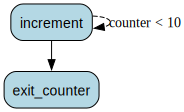

In [3]:
from burr.core import ApplicationBuilder, expr, default
from burr.core.graph import GraphBuilder
graph = (
    GraphBuilder()
    .with_actions(increment, exit_counter)
    .with_transitions(
        ("increment", "increment", expr("counter < 10")),
        ("increment", "exit_counter", default),
    ).build()
)
graph

# Running the Graph

In [8]:
app = (
    ApplicationBuilder()
    .with_graph(graph)
    .with_state(counter=0)
    .with_entrypoint("increment")
    .build()
)
action_obj, result, state = app.run(halt_after=["exit_counter"])

Count:  6


# Multi-modal example:

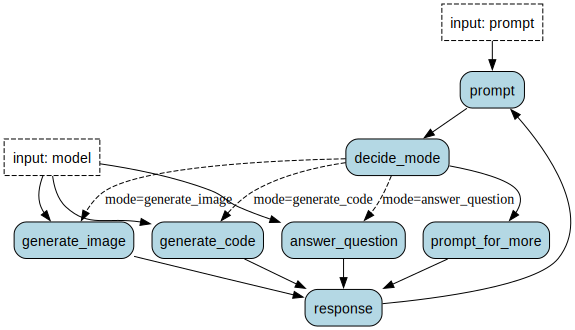

In [12]:
import copy

import openai

from burr.core import State, default, graph, when
from burr.core.action import action

MODES = {
    "answer_question": "text",
    "generate_image": "image",
    "generate_code": "code",
    "unknown": "text",
}


@action(reads=[], writes=["chat_history", "prompt"])
def process_prompt(state: State, prompt: str) -> State:
    result = {"chat_item": {"role": "user", "content": prompt, "type": "text"}}
    state = state.append(chat_history=result["chat_item"])
    state = state.update(prompt=prompt)
    return state


@action(reads=["prompt"], writes=["mode"])
def choose_mode(state: State) -> State:
    prompt = (
        f"You are a chatbot. You've been prompted this: {state['prompt']}. "
        f"You have the capability of responding in the following modes: {', '.join(MODES)}. "
        "Please respond with *only* a single word representing the mode that most accurately "
        "corresponds to the prompt. Fr instance, if the prompt is 'draw a picture of a cat', "
        "the mode would be 'generate_image'. If the prompt is "
        "'what is the capital of France', the mode would be 'answer_question'."
        "If none of these modes apply, please respond with 'unknown'."
    )

    llm_result = openai.Client().chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant"},
            {"role": "user", "content": prompt},
        ],
    )
    content = llm_result.choices[0].message.content
    mode = content.lower()
    if mode not in MODES:
        mode = "unknown"
    result = {"mode": mode}
    return state.update(**result)


@action(reads=["prompt", "chat_history"], writes=["response"])
def prompt_for_more(state: State) -> State:
    result = {
        "response": {
            "content": "None of the response modes I support apply to your question. "
                       "Please clarify?",
            "type": "text",
            "role": "assistant",
        }
    }
    return state.update(**result)


@action(reads=["prompt", "chat_history", "mode"], writes=["response"])
def chat_response(
        state: State, prepend_prompt: str, model: str = "gpt-3.5-turbo"
) -> State:
    
    chat_history = copy.deepcopy(state["chat_history"])
    chat_history[-1]["content"] = f"{prepend_prompt}: {chat_history[-1]['content']}"
    chat_history_api_format = [
        {
            "role": chat["role"],
            "content": chat["content"],
        }
        for chat in chat_history
    ]
    client = openai.Client()
    result = client.chat.completions.create(
        model=model,
        messages=chat_history_api_format,
    )
    text_response = result.choices[0].message.content
    result = {"response": {"content": text_response, "type": MODES[state["mode"]], "role": "assistant"}}
    return state.update(**result)


@action(reads=["prompt", "chat_history", "mode"], writes=["response"])
def image_response(state: State, model: str = "dall-e-2") -> State:
    """Generates an image response to the prompt. Optional save function to save the image to a URL."""
    # raise ValueError("Demo error")
    client = openai.Client()
    result = client.images.generate(
        model=model, prompt=state["prompt"], size="1024x1024", quality="standard", n=1
    )
    image_url = result.data[0].url
    result = {"response": {"content": image_url, "type": MODES[state["mode"]], "role": "assistant"}}
    return state.update(**result)


@action(reads=["response", "mode"], writes=["chat_history"])
def response(state: State) -> State:
    # you'd do something specific here based on prior state
    result = {"chat_item": state["response"]}
    return state.append(chat_history=result["chat_item"])

base_graph = (
    graph.GraphBuilder()
    .with_actions(
        # these are the "nodes" 
        prompt=process_prompt,
        decide_mode=choose_mode,
        generate_image=image_response,
        generate_code=chat_response.bind(
            prepend_prompt="Please respond with *only* code and no other text (at all) to the following:",
        ),
        answer_question=chat_response.bind(
            prepend_prompt="Please answer the following question:",
        ),
        prompt_for_more=prompt_for_more,
        response=response,
    )
    .with_transitions(
        # these are the edges between nodes, based on state.
        ("prompt", "decide_mode", default),
        ("decide_mode", "generate_image", when(mode="generate_image")),
        ("decide_mode", "generate_code", when(mode="generate_code")),
        ("decide_mode", "answer_question", when(mode="answer_question")),
        ("decide_mode", "prompt_for_more", default),
        (
            ["generate_image", "answer_question", "generate_code", "prompt_for_more"],
            "response",
        ),
        ("response", "prompt", default),
    )
    .build()
)
base_graph

# Adding Instrumentation & Running it
Just a one line change...

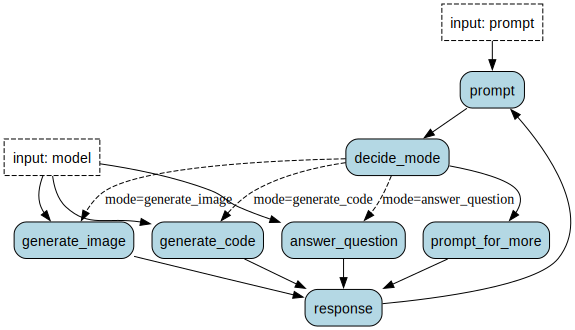

In [14]:
from burr.tracking import LocalTrackingClient
from opentelemetry.instrumentation.openai import OpenAIInstrumentor
# this will auto instrument the openAI client. No swapping of imports required!
OpenAIInstrumentor().instrument()

tracker = LocalTrackingClient(project="agent-demo-new")
app = (
    ApplicationBuilder()
    .with_graph(base_graph)
    .initialize_from(
        tracker, 
        resume_at_next_action=True, 
        default_state={"chat_history": []},
        default_entrypoint="prompt",
    )
    .with_tracker(tracker, use_otel_tracing=True)  # tracking + checkpointing; one line 🪄.
    .build()
)
app

# Annotation
Let's create some data.

In [15]:
from IPython.display import Image, display 

while True:
    user_input = input("Hi, how can I help?")
    if "quit" == user_input.lower():
        break
    last_action, action_result, app_state = app.run(
        halt_after=["response"], 
        inputs={"prompt": user_input}
    )
    last_message = app_state["chat_history"][-1]
    if last_message['type'] == 'image':
        display(Image(url=last_message["content"]))
    else:
        print(f"🤖: {last_message['content']}")

🤖: France is located in Western Europe.
🤖: ```java
public class HelloWorld {
    public static void main(String[] args) {
        System.out.println("Hello, World!");
    }
}
```
🤖: ```javascript
console.log("Hello, World!");
```


[Open the UI - http://localhost:7241/](http://localhost:7241)


# Iteration, Debugging, Test cases

## Replaying from a specific point in time
"Forking"

In [16]:
# show forking state.
app_id = "d34db1e4-a265-4871-b47f-a6c08bd6860d"
sequence_id = 5
# partition_key = ""

forked_app = (
    ApplicationBuilder()
    .with_graph(base_graph) # this could be different...
    .initialize_from(
        tracker,
        resume_at_next_action=True, 
        default_state={"chat_history": []},
        default_entrypoint="prompt",
        fork_from_app_id=app_id,
        fork_from_sequence_id=sequence_id,
        # fork_from_partition_key=partition_key
    )
    .with_tracker(tracker, use_otel_tracing=True)
    .build()
)
forked_app.state["chat_history"]

[{'role': 'user', 'content': 'where is france located?', 'type': 'text'},
 {'content': 'France is located in Western Europe.',
  'type': 'text',
  'role': 'assistant'},
 {'role': 'user', 'content': 'write hello world in java.', 'type': 'text'}]

In [17]:
while True:
    user_input = input("Hi, how can I help?")
    if "quit" == user_input.lower():
        break
    last_action, action_result, app_state = forked_app.run(
        halt_after=["response"], 
        inputs={"prompt": user_input}
    )
    last_message = app_state["chat_history"][-1]
    if last_message['type'] == 'image':
        display(Image(url=last_message["content"]))
    else:
        print(f"🤖: {last_message['content']}")

🤖: ```java
public class HelloWorld {
    public static void main(String[] args) {
        System.out.println("Hello, World!");
    }
}
```


## Can create test cases using saved data

In [18]:
!burr-test-case create  \
  --project-name "agent-demo-new" \
  --partition-key "null" \
  --app-id "f5394eab-827d-4625-a446-6d38f53c9208" \
  --sequence-id 7 \
  --target-file-name YOUR_FIXTURE_FILE.json 


Action was successful so loading initial and expected state into test fixture.

Writing data to file YOUR_FIXTURE_FILE.json

Add the following to your test file:

import pytest
from burr.core import state
from burr.testing import pytest_generate_tests  # noqa: F401
# TODO: import action you're testing, i.e. import response.

@pytest.mark.file_name("YOUR_FIXTURE_FILE.json")
def test_response(input_state, expected_state):
    """Function for testing the action"""
    input_state = state.State.deserialize(input_state)
    expected_state = state.State.deserialize(expected_state)
    _, output_state = response(input_state)  # exercise the action
    # TODO: choose appropriate way to evaluate the output
    # e.g. exact match, fuzzy match, LLM grade, etc.
    # this is exact match here on all values in state
    assert output_state == expected_state
    # e.g.
    # assert 'some value' in output_state["response"]["content"]
    # assert llm_evaluator(..., ...) == "Y"

